In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable

In [2]:
import seaborn as sns
sns.set()

## Background and problem statement
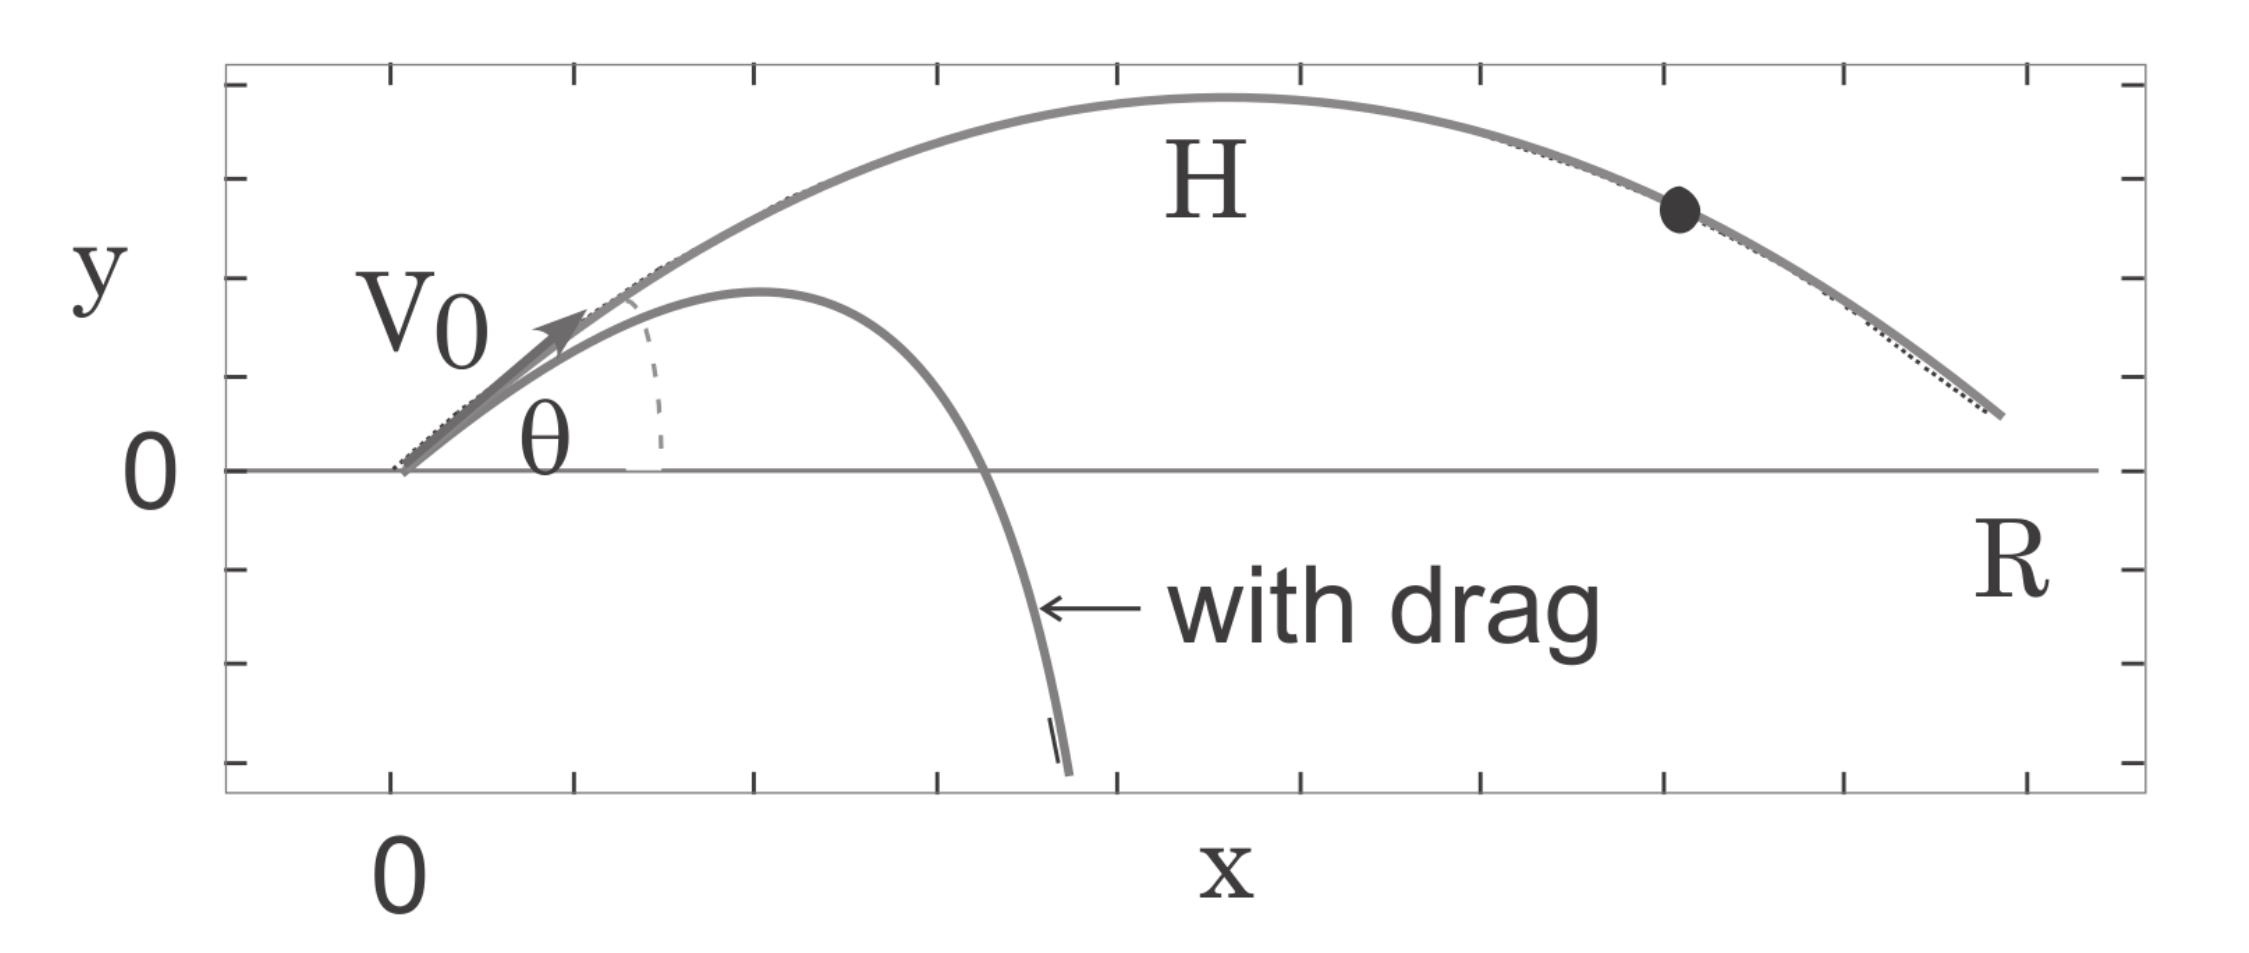

In the picture you can see trajectories for a projectile shot at inclination $\Theta$ and with an initial velocity $v_0$. If we ignore air resistance, the projectile has only the (height-independent) force of gravity acting on it and the trajectory will be a parabola with range $R=2 v_0^2 \sin (\Theta) \cos (\Theta) / g$ and maximum height $H=\frac{1}{2} v_0^2 \sin ^2(\Theta) / g$. Because a parabola is symmetric about its midpoint, it does not describe what appears to be a sharp, nearly vertical, drop-off of baseballs and golf balls near the end of their trajectories.

In this work different models of damping force were investigated in order to reproduce this behavior in simulation. 


### Some theory

The damping force will be assumed to be proportional to some power of velocity modulus and has an opposite to the velocity direction. 

Task: Rewrite these equations into first-order differential equations
$$
\frac{d^2 x}{d t^2}=-k|v|^{n-1} v_x, \quad \frac{d^2 y}{d t^2}=-k|v|^{n-1} v_y-g, \quad|v|=\sqrt{v_x^2+v_y^2}
$$

Solution:

$$
\frac{d v_x}{d t}=-k|v|^{n-1} v_x, \quad \frac{d v_y}{d t}=-k|v|^{n-1} v_y-g, \quad|v|=\sqrt{v_x^2+v_y^2}
$$


## Movement integration

In [3]:
class Body:
    def __init__(self, r_0, m, v_0=0):
        '''
        r_0 -- n-dim initial coordinate [m]
        m -- mass in [kg]
        v_0 -- n-dim initial velocity in [m/s]
        '''
        self.r = r_0 if isinstance(r_0, np.ndarray) else np.array(r_0, dtype=float)
        self.v = v_0 if isinstance(v_0, np.ndarray) else np.array(v_0, dtype=float)
        self.m = m

def body_factory():
    return Body(5000, 3)

n = 1

def acceleration(r, v, m):
    g = 9.81
    v_abs = np.linalg.norm(v)
    k = 0.8 # damping coefficient
    grav_f = np.array([0, -g*m])
    damp_f = -v*k*v_abs**(n-1)
    return (grav_f + damp_f)/m



In [4]:
def stop_criteria(body, step):
    return body.r[1] < 0

def drop_the_body(body: Body, accel_function: Callable, step_integration: Callable, dt=0.01):
    metrics = {
        "r": [],
        "v": [],
        "t": [],
        "a": [],
    }
    t = 0
    max_steps = 100_000
    step = 0
    while not stop_criteria(body, step):
        a = accel_function(body.r, body.v, body.m)
        metrics["r"].append(body.r)
        metrics["v"].append(body.v)
        metrics["t"].append(t)
        metrics["a"].append(a)
        
        step_integration(body, dt, accel_function)        
        
        t += dt
        step+=1
        if (step > max_steps):
            print("Max steps reached")
            break
    print(f"Done {step} steps")
    return metrics

def euler_step_integration(body: Body, dt, accel_function):
    a = accel_function(body.r, body.v, body.m)
    body.r = body.r + body.v*dt
    body.v = body.v + a*dt

In [5]:
angle = 34/180*np.pi
body = Body([0, 0], 1, np.array([np.cos(angle), np.sin(angle)])*22)
euler_metrics = drop_the_body(body, acceleration, euler_step_integration)

Done 201 steps


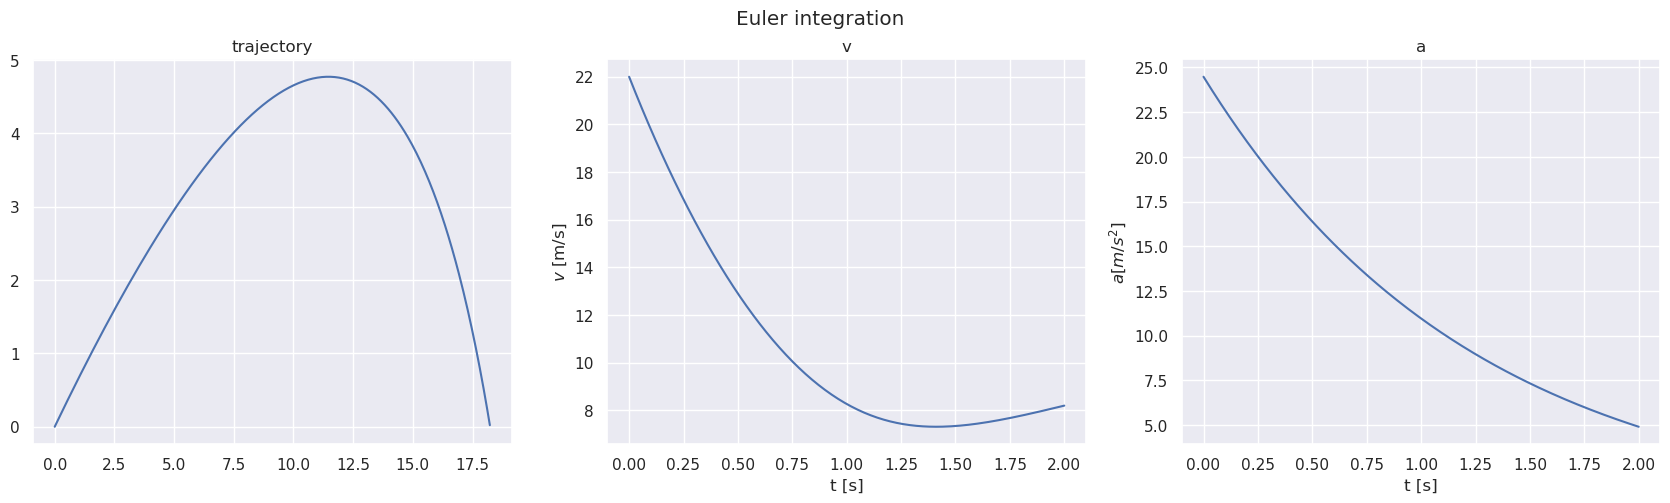

In [6]:
def plot_metrics(metrics):
    y_labels = ["r", "v", "a"]
    y_legend_labels = ["y [m]", "$v$ [m/s]", "$a [m/s^2]$"]
    
    plt.figure(figsize=(7*len(y_labels), 5))
    
    plt.subplot(1, len(y_labels), 1)
    plt.title("trajectory")
    r = np.array(metrics[y_labels[0]])
    plt.plot(r[:, 0], r[:, 1])
    
    for i, label in enumerate(y_labels[1:], 1):
        plt.subplot(1, len(y_labels), i+1)
        plt.plot(metrics['t'], [np.linalg.norm(t) for t in metrics[label]])
        plt.ylabel(y_legend_labels[i])
        plt.xlabel("t [s]")
        plt.title(label)

plot_metrics(euler_metrics)
plt.suptitle("Euler integration");

## $dt$ investigation

dt was chosen to be 0.01. It was chosen based on number of intermediate points along the trajectory around 200 which is sufficient for our case for velocity to change slightly during the fall (see plot $v(t)$). And further increasing of integration precision 10 or 100 times doesn't change curves significantly. Though, as our main interest is trajectory form -- $dt$ is small enough. 

### Other integration methods

In [7]:
def euler_richardson_step_integration(body: Body, dt, accel_function):
    a = accel_function(body.r, body.v, body.m)
    v_mid = body.v + a*dt/2
    r_mid = body.r + body.v*dt/2
    a_mid = accel_function(r_mid, v_mid, body.m)
    body.r = body.r + v_mid*dt
    body.v = body.v + a_mid*dt

In [8]:
angle = 34/180*np.pi
body = Body([0, 0], 1, np.array([np.cos(angle), np.sin(angle)])*22)
euler_rich_metrics = drop_the_body(body, acceleration, euler_richardson_step_integration, dt=0.01)

Done 200 steps


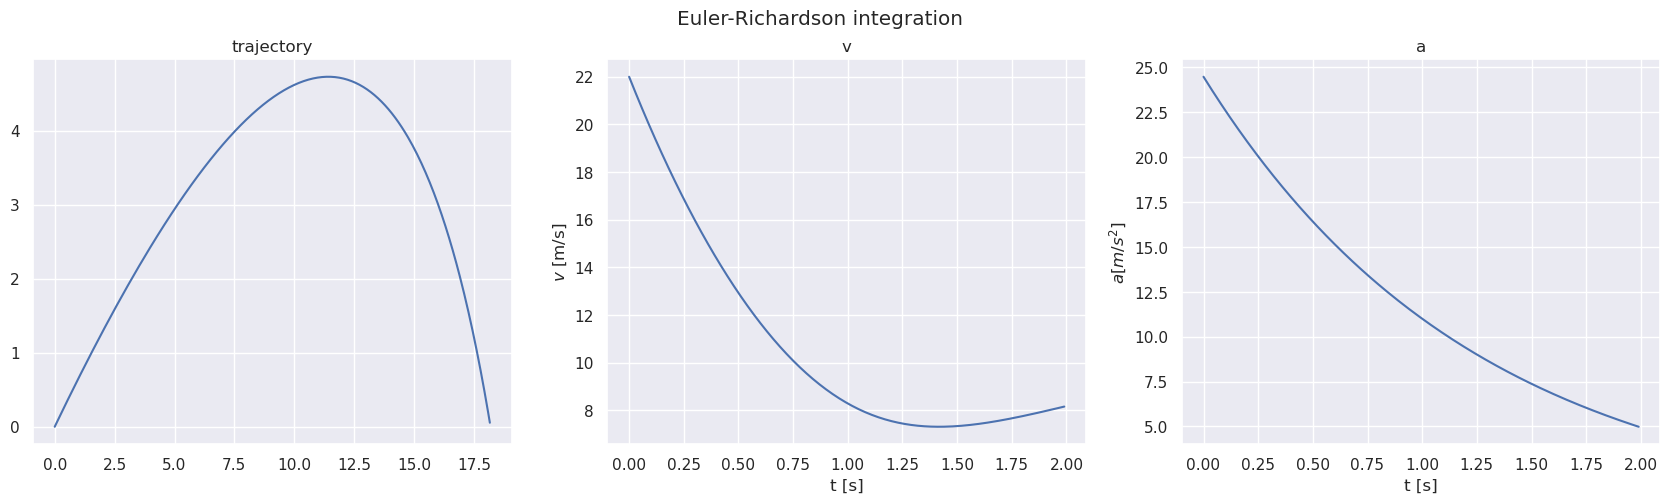

In [9]:
plot_metrics(euler_rich_metrics)
plt.suptitle("Euler-Richardson integration");

## Integration methods correctness
The integration methods are the same as in previous task, where they were tested in free falling with friction and on harmonic oscillator. Thus they are believed to be correct.
To be even more satisfied lets compare it with case without friction

Done 251 steps
max hight 7.713742345445523 against predicted 7.713822853891401
fall distance 45.59706649052749 against predicted 45.74485072480378


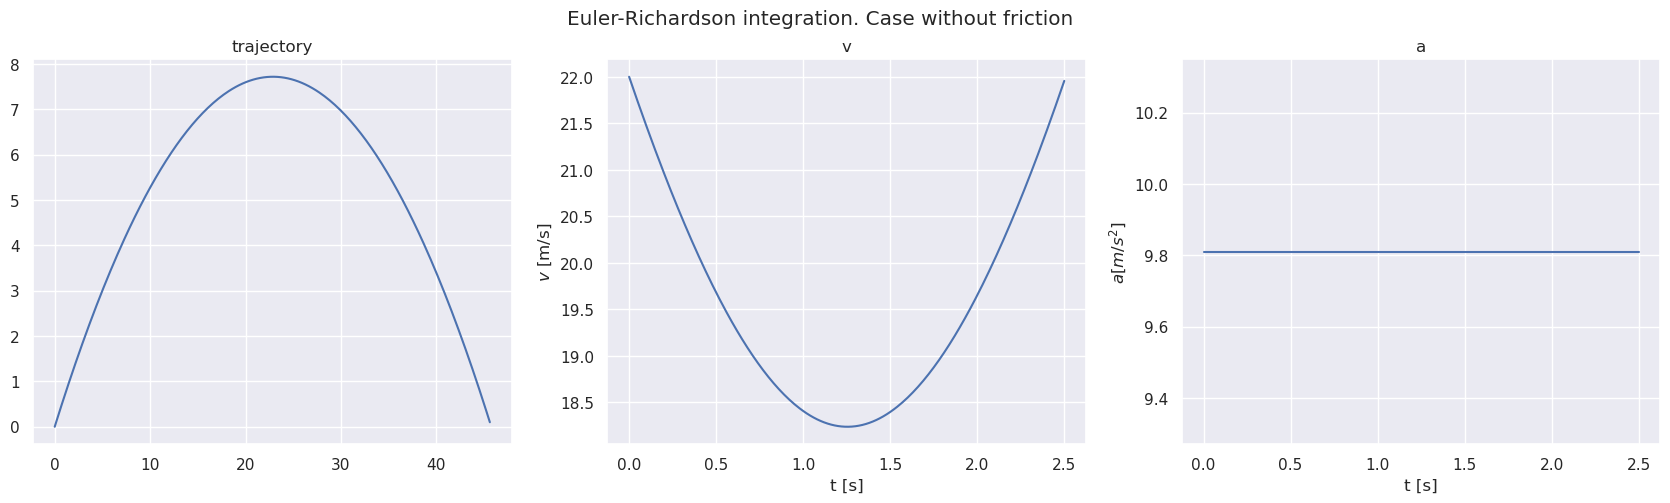

In [10]:
n = 1

def acceleration(r, v, m):
    g = 9.81
    v_abs = np.linalg.norm(v)
    k = 0 # damping coefficient
    grav_f = np.array([0, -g*m])
    damp_f = -v*k*v_abs**(n-1)
    return (grav_f + damp_f)/m

angle = 34/180*np.pi
body = Body([0, 0], 1, np.array([np.cos(angle), np.sin(angle)])*22)
euler_rich_metrics = drop_the_body(body, acceleration, euler_richardson_step_integration, dt=0.01)

plot_metrics(euler_rich_metrics)
plt.suptitle("Euler-Richardson integration. Case without friction");

print(f"max hight {max([r[1] for r in euler_rich_metrics['r']])} against predicted {0.5*22**2*np.sin(angle)**2/9.81}")
print(f"fall distance {max([r[0] for r in euler_rich_metrics['r']])} against predicted {2*22**2*np.sin(angle) *np.cos(angle)/9.81}")

### Different $n$-s for friction dependency

To keep the initial dumping the same, friction coefficient has to obey:
$$ k_n \cdot |v_0|^n = k_1 \cdot |v_0| $$
$$k_n = k_1/|v_0|^{n-1}$$

In [11]:
n = 2

def acceleration(r, v, m):
    g = 9.81
    v_abs = np.linalg.norm(v)
    k = 0.8/22**(n-1) # damping coefficient
    grav_f = np.array([0, -g*m])
    damp_f = -v*k*v_abs**(n-1)
    return (grav_f + damp_f)/m

Done 200 steps
Done 200 steps
Done 202 steps


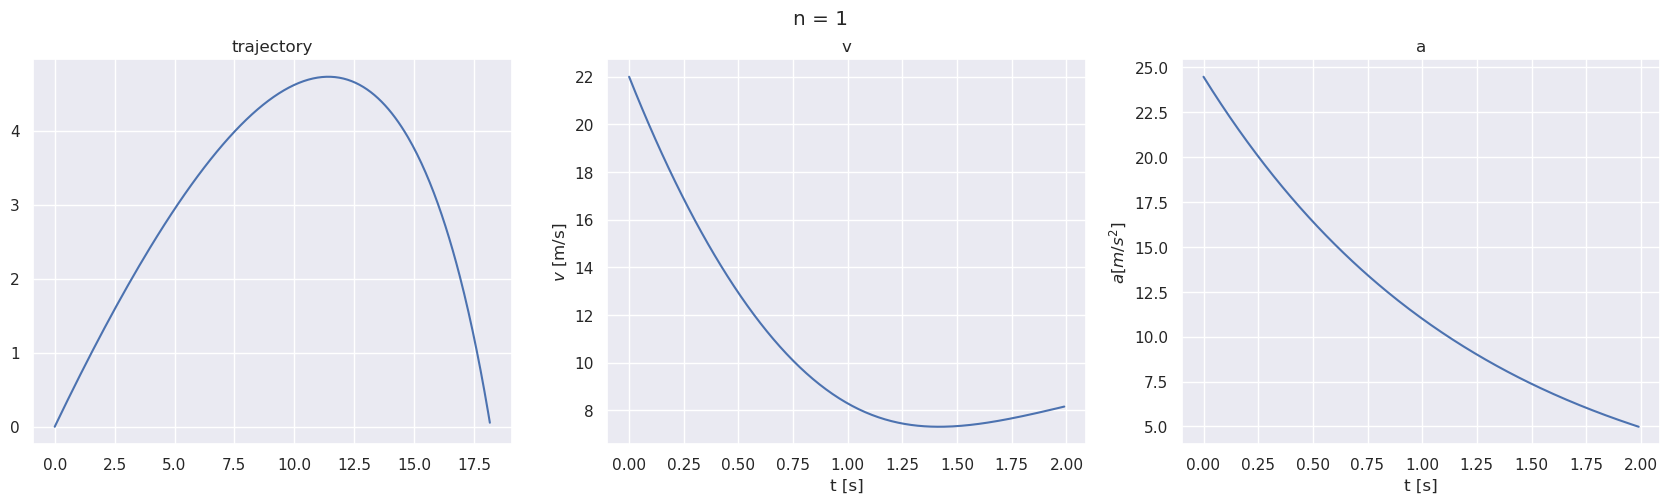

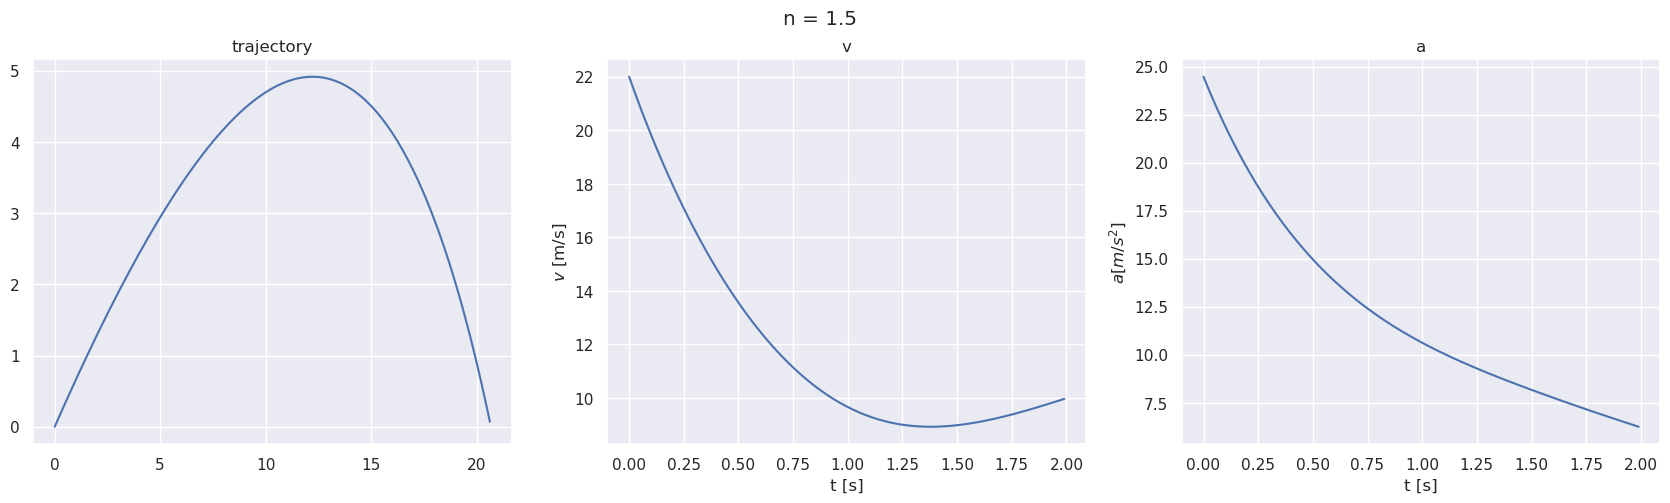

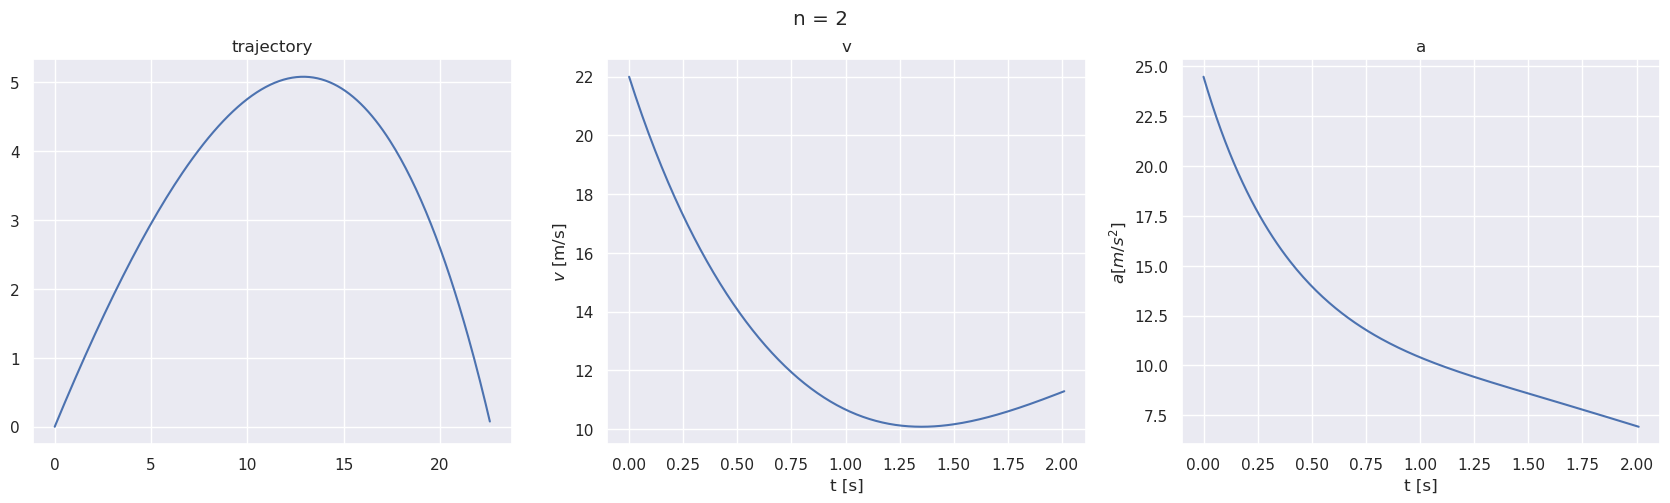

In [12]:
n_list = [1, 3/2, 2]
for n in n_list:
    angle = 34/180*np.pi
    body = Body([0, 0], 1, np.array([np.cos(angle), np.sin(angle)])*22)
    euler_rich_metrics = drop_the_body(body, acceleration, euler_richardson_step_integration, dt=0.01)
    plot_metrics(euler_rich_metrics)
    plt.suptitle(f"n = {n}");

## More different n-s and T, R dependencies

Done 363 steps
Done 213 steps
Done 204 steps
Done 200 steps
Done 200 steps
Done 202 steps
Done 207 steps


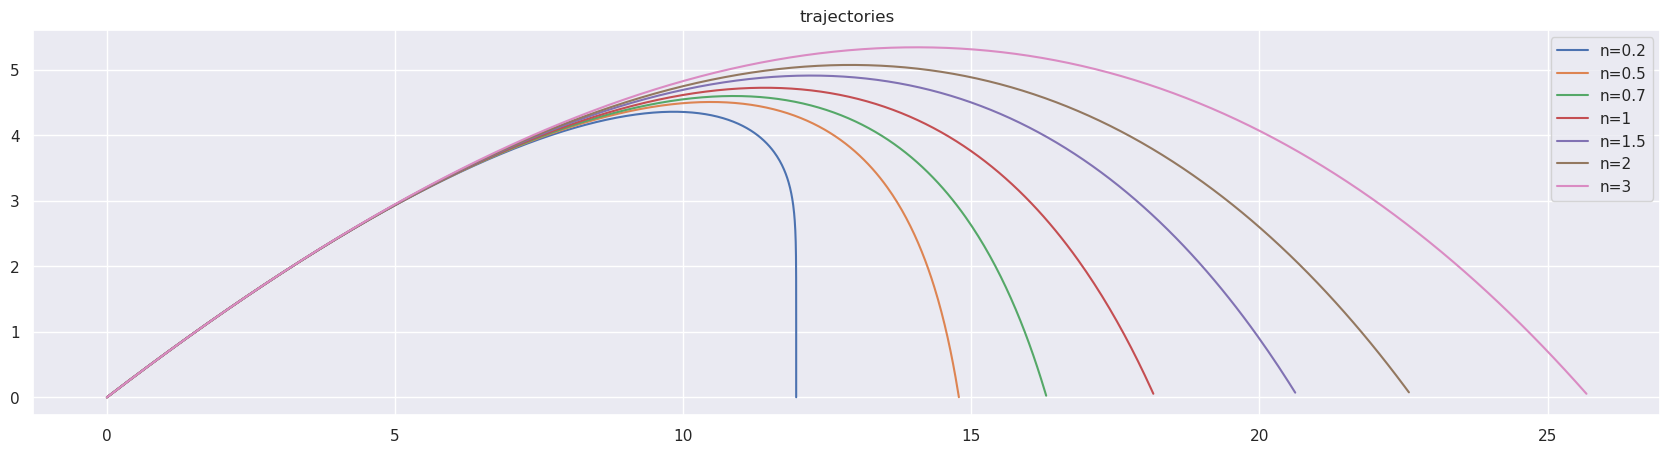

''

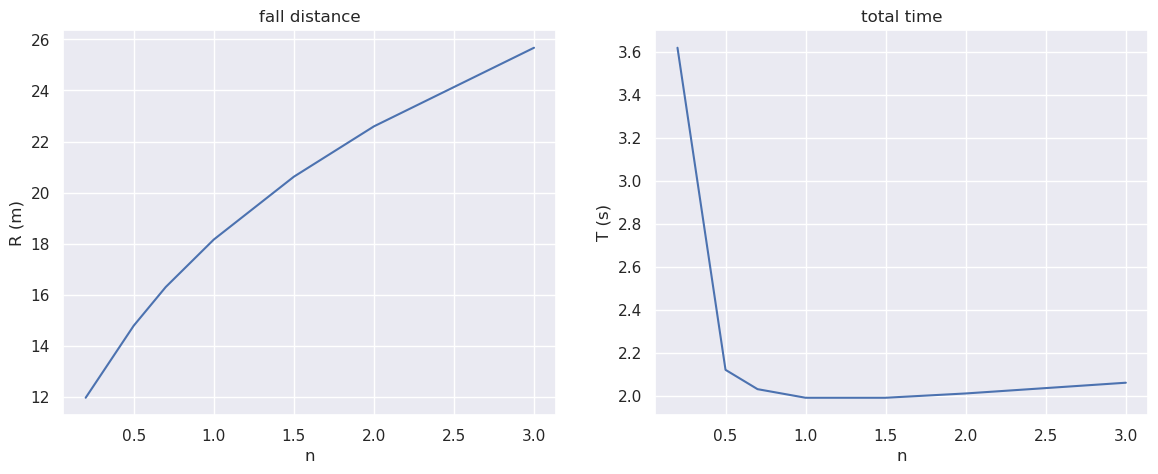

In [13]:
n_list = [0.2, 0.5, 0.7, 1, 3/2, 2, 3]
R_list = []
T_list = []

plt.figure(figsize=(7*3, 5))
# plt.subplot(1, 3, 1)
for n in n_list:
    angle = 34/180*np.pi
    body = Body([0, 0], 1, np.array([np.cos(angle), np.sin(angle)])*22)
    metrics = drop_the_body(body, acceleration, euler_richardson_step_integration, dt=0.01)
    r = np.array(metrics["r"])
    T = metrics["t"][-1]
    T_list.append(T)
    R = r[-1, 0]
    R_list.append(R)
    
    plt.plot(r[:, 0], r[:, 1], label=f"n={n}")
    
plt.legend();
plt.title("trajectories")
plt.show()
plt.figure(figsize=(7*2, 5))
plt.subplot(1, 2, 1)
plt.plot(n_list, R_list)
plt.xlabel("n")
plt.ylabel("R (m)")
plt.title("fall distance")

plt.subplot(1, 2, 2)
plt.plot(n_list, T_list)
plt.xlabel("n")
plt.ylabel("T (s)")
plt.title("total time")
;

### Conclusion

As seen from the trajectories for different powers of velocity in friction law, the less is the power, the more vertical is the falling.

For extreme case of $n$=0.2 it is straight vertical line, and for $n$ around 0.7-1 the picture look close to one observed in the experiment. 

For bigger powers, trajectory is closer to one without friction and falling angle is close to the initial angle.

This is intuitive, as for high $n$ damping force decays very fast with the decrease of velocity, while with small $n$ it decreases slowly and significantly affects the trajectory of slowly falling body in the end by removing the horizontal velocity component almost completely. 

This is also a reason, why R increases with n approaching value for falling without friction. Falling time rapidly increases when body has time to loose all initial speed (with smallest $n$) 